<a href="https://www.kaggle.com/code/infistforever/vechice-plate-ocr?scriptVersionId=186020273" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q datasets jiwer

In [2]:
import os
import time
import numpy as np
import pandas as pd

import cv2
import json
from PIL import Image

output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

In [3]:
from bs4 import BeautifulSoup 

def get_string(file):

    with open(file, 'r') as f:
        data = f.read() 

    # Passing the stored data inside the beautifulsoup parser 
    bs_data = BeautifulSoup(data, 'xml') 

    # Finding all instances of tag   
    b_unique = bs_data.find_all('object') 
    return ''.join([i.find('name').text for i in b_unique])

def yolo_to_abs(data_dict):#, scale=100.0):
    cord = {}

    original_width = data_dict['original_width']
    original_height = data_dict['original_height']
    
    pixel_x = int(data_dict['x']/100. * original_width)
    pixel_y = int(data_dict['y']/100. * original_height)
    pixel_width = int(data_dict['width']/100. * original_width)
    pixel_height = int(data_dict['height']/100. * original_height)
#     return[pixel_x, pixel_y, pixel_width, pixel_height]
    cord['x1'] = pixel_x -2#- pixel_width #/2)*original_width
    cord['y1'] = pixel_y -2#- pixel_height#/2)*original_height
    cord['x2'] = pixel_x + pixel_width +5 #/2)*original_width
    cord['y2'] = pixel_y + pixel_height + 5#/2)*original_height
    return cord

In [4]:
def preprocess(image, width: int, height: int, cval: int = 255, mode="letterbox", return_scale=False,):
    """Obtain a new image, fit to the specified size.
    Args:
        image: The input image
        width: The new width
        height: The new height
        cval: The constant value to use to fill the remaining areas of
            the image
        return_scale: Whether to return the scale used for the image
    Returns:
        The new image
    """
    fitted = None
    x_scale = width / image.shape[1]
    y_scale = height / image.shape[0]
    if x_scale == 1 and y_scale == 1:
        fitted = image
        scale = 1
    elif (x_scale <= y_scale and mode == "letterbox") or (
        x_scale >= y_scale and mode == "crop"
    ):
        scale = width / image.shape[1]
        resize_width = width
        resize_height = (width / image.shape[1]) * image.shape[0]
    else:
        scale = height / image.shape[0]
        resize_height = height
        resize_width = scale * image.shape[1]
    if fitted is None:
        resize_width, resize_height = map(int, [resize_width, resize_height])
        if mode == "letterbox":
            fitted = np.zeros((height, width, 3), dtype="uint8") + cval
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted[: image.shape[0], : image.shape[1]] = image[:height, :width]
        elif mode == "crop":
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted = image[:height, :width]
        else:
            raise NotImplementedError(f"Unsupported mode: {mode}")
    if not return_scale:
        return fitted
    return fitted, scale

# Process license-plate-characters-detection-ocr 

In [5]:
image_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images'
annotations_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations'
    
lic_record = []

for im_name in sorted(os.listdir(image_dir)):
    image_path = os.path.join(image_dir, im_name)

    annot_path = os.path.join(annotations_dir, im_name.split('.')[0]+'.xml')      
    label_string = get_string(annot_path)

    lic_record.append(dict(text=str(label_string), file_name=image_path))
    

In [6]:
df1 = pd.DataFrame(lic_record)
df1.to_csv('/kaggle/working/lic_labels1.csv')

df1.head()


,text,file_name
0,MH15TC554,/kaggle/input/license-plate-characters-detecti...
1,MH02CB4545,/kaggle/input/license-plate-characters-detecti...
2,KA031351,/kaggle/input/license-plate-characters-detecti...
3,TN0600000,/kaggle/input/license-plate-characters-detecti...
4,KA51MJ8156,/kaggle/input/license-plate-characters-detecti...


In [7]:
df1

,text,file_name
0,MH15TC554,/kaggle/input/license-plate-characters-detecti...
1,MH02CB4545,/kaggle/input/license-plate-characters-detecti...
2,KA031351,/kaggle/input/license-plate-characters-detecti...
3,TN0600000,/kaggle/input/license-plate-characters-detecti...
4,KA51MJ8156,/kaggle/input/license-plate-characters-detecti...
...,...,...
204,MH2OBN3525,/kaggle/input/license-plate-characters-detecti...
205,MH01AR5274,/kaggle/input/license-plate-characters-detecti...
206,MH20CS1941,/kaggle/input/license-plate-characters-detecti...
207,H20CS1938,/kaggle/input/license-plate-characters-detecti...


# Process car-plate-detection dataset

In [8]:
license_no_data = pd.read_csv('/kaggle/input/tags-licenseplate/ocr-licence-plate.csv')
# license_no_data = license_no_data.sample(frac = 1)
license_no_data['ocr'] = license_no_data['ocr'].apply(lambda x: x.split('-')[-1])

license_no_data

,ocr,id,bbox,label,transcription,annotator,annotation_id,created_at,updated_at,lead_time
0,Cars430.png,431,"[{""x"": 11.066398390342053, ""y"": 72.5, ""width"":...","[{""x"": 11.066398390342053, ""y"": 72.5, ""width"":...",BCG-986,1,314,2023-03-09T11:29:21.270803Z,2023-03-09T11:29:21.270849Z,11.090
1,Cars429.png,430,"[{""x"": 32.62032085561498, ""y"": 41.851106639839...","[{""x"": 32.62032085561498, ""y"": 41.851106639839...",KA1SER,1,313,2023-03-09T11:29:07.437858Z,2023-03-09T11:29:07.437904Z,13.608
2,Cars427.png,428,"[{""x"": 41.04627766599598, ""y"": 43.699731903485...","[{""x"": 41.04627766599598, ""y"": 43.699731903485...",01 CC 1A 0001,1,312,2023-03-09T11:28:48.305793Z,2023-03-09T11:28:48.305844Z,13.518
3,Cars426.png,427,"[{""x"": 41.85110663983904, ""y"": 68.632707774798...","[{""x"": 41.85110663983904, ""y"": 68.632707774798...",CRAIG,1,311,2023-03-09T11:28:30.687784Z,2023-03-09T11:28:30.687842Z,13.059
4,Cars425.png,426,"[{""x"": 42.45472837022133, ""y"": 46.320346320346...","[{""x"": 42.45472837022133, ""y"": 46.320346320346...",G526JHD,1,310,2023-03-09T11:28:14.569265Z,2023-03-09T11:28:14.569302Z,20.648
...,...,...,...,...,...,...,...,...,...,...
309,Cars4.png,5,"[{""x"": 26.559356136820927, ""y"": 25.42372881355...","[{""x"": 26.559356136820927, ""y"": 25.42372881355...",PUI8BES,1,5,2023-03-09T07:34:52.009265Z,2023-03-09T07:34:52.009298Z,24.077
310,Cars3.png,4,"[{""x"": 35.2112676056338, ""y"": 55.7142857142857...","[{""x"": 35.2112676056338, ""y"": 55.7142857142857...",DZI7YXR,1,4,2023-03-09T07:34:25.449170Z,2023-03-09T07:34:25.449216Z,13.863
311,Cars2.png,3,"[{""x"": 57.29972246043483, ""y"": 43.923670974270...","[{""x"": 57.29972246043483, ""y"": 43.923670974270...",PRE-NUP,1,3,2023-03-09T07:34:08.941012Z,2023-03-09T07:34:08.941056Z,17.317
312,Cars1.png,2,"[{""x"": 34.390806447042095, ""y"": 51.59992211332...","[{""x"": 34.390806447042095, ""y"": 51.59992211332...",PG-MN112,1,2,2023-03-09T07:27:38.964069Z,2023-03-09T07:27:38.964130Z,45.524


In [9]:
lic_record = []
path_car_img = "/kaggle/input/car-plate-detection/images"
os.makedirs("/kaggle/working/images/", exist_ok=True)
for row, val in  license_no_data.iterrows():                         # need improvement
    img_dir = os.path.join(path_car_img, val['ocr'])
    image = cv2.imread(img_dir, cv2.IMREAD_ANYCOLOR)
    try:
        label_s = json.loads(val['transcription'])
    except ValueError:
        label_s = str(val['transcription'])
    for num, bbox in enumerate(json.loads(val['bbox'])):
        path_to_save = f"/kaggle/working/images/{val['ocr'].split('.')[0]}_{num}.jpg"

        cart_cord = yolo_to_abs(bbox)
        crop_img = image[cart_cord['y1']:cart_cord['y2'],
                         cart_cord['x1']:cart_cord['x2']]
        crop_img = preprocess(crop_img, width=200, height=100)

#         process_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY) #.astype("float32")[..., np.newaxis]
        im_croped = Image.fromarray(crop_img)
        
        im_croped.save(path_to_save)
        if isinstance(label_s, list):
            lic_record.append( dict(text=str(label_s[num]), file_name=path_to_save))
        else:
            lic_record.append(dict(text=str(label_s), file_name = path_to_save))

In [10]:
df2 = pd.DataFrame(lic_record)
df2.to_csv('/kaggle/working/lic_labels.csv')
df2.sort_values('file_name', inplace=True)
df2

,text,file_name
339,KL01CA2555,/kaggle/working/images/Cars0_0.jpg
243,WW 95550,/kaggle/working/images/Cars100_0.jpg
242,68-611-36,/kaggle/working/images/Cars102_0.jpg
241,NL60LXB,/kaggle/working/images/Cars104_0.jpg
240,J966S,/kaggle/working/images/Cars105_0.jpg
...,...,...
247,KA05MG1909,/kaggle/working/images/Cars97_0.jpg
246,YWORRY,/kaggle/working/images/Cars98_0.jpg
244,2662,/kaggle/working/images/Cars99_0.jpg
245,KA-09,/kaggle/working/images/Cars99_1.jpg


## Mixing datasets

In [11]:
from sklearn.model_selection import train_test_split

test_df = pd.concat([df1[-21:],df2[-21:]])
df = pd.concat([df1[:-21], df2[:-21]])
# train_df, valid_df = train_test_split(df[:-21], test_size=0.2)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
print(df1.shape, df2.shape)
print(train_df.shape, valid_df.shape,test_df.shape)

(209, 2) (340, 2)
(405, 2) (102, 2) (42, 2)


# Download/Load Model

In [13]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torch
from torch.utils.data import Dataset

class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [15]:
root_dir = ''

train_dataset = LPDataset(root_dir, df=train_df, processor=processor)

test_dataset = LPDataset(root_dir, df=test_df, processor=processor)

eval_dataset = LPDataset(root_dir, df=valid_df, processor=processor)

In [16]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [17]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [18]:
processor.tokenizer('AOCED', padding="max_length", max_length=50).input_ids

[0,
 250,
 4571,
 1691,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [19]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [20]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [21]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
#     fp16=True, 
    overwrite_output_dir=True,
    output_dir=output_dir,
    logging_steps=2,
    save_steps=500,
    eval_steps=200,
    report_to="none",
    num_train_epochs=4,
)


# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [22]:
train_time = time.time() ## in UTC time
trainer.train()
train_time = time.time() - train_time

print('Train time (sec)', train_time)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


Train time (sec) 219.34511184692383


In [23]:
pip install transformers matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [24]:
save_time = time.time()
model.save_pretrained("/kaggle/working/vit-ocr")
save_time = time.time() - save_time
print('save_time time (sec)', save_time)

save_time time (sec) 1.7832727432250977


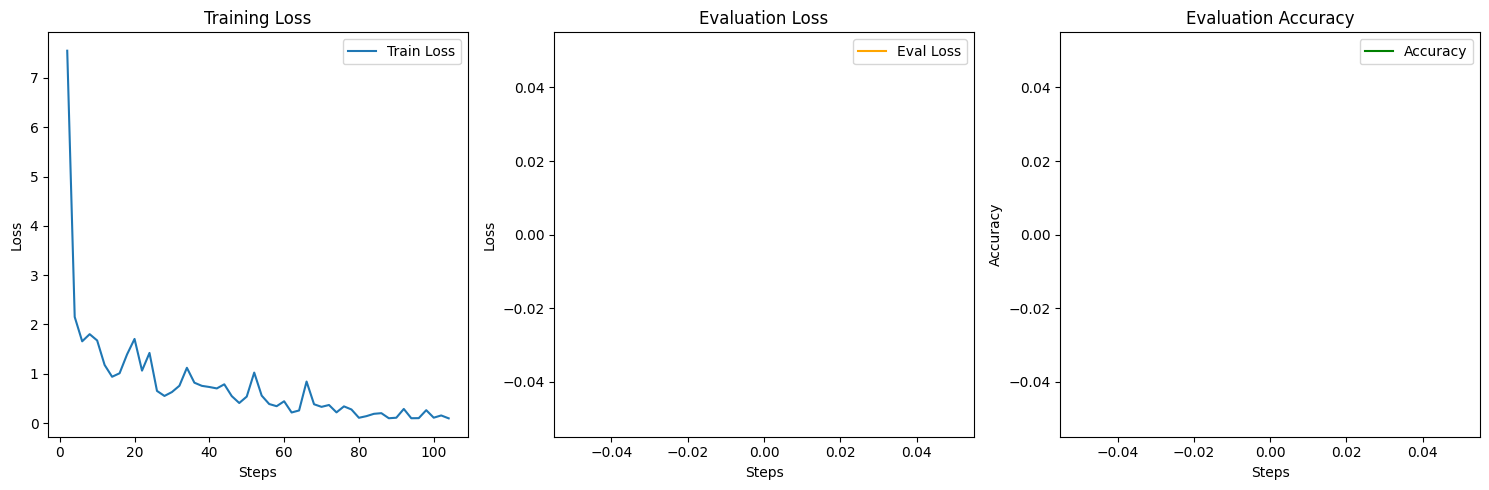

In [25]:
import matplotlib.pyplot as plt
import time
log_history = trainer.state.log_history

steps = []
train_loss = []
eval_loss = []
accuracy = []

for entry in log_history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        steps.append(entry['step'])
    if 'val_loss' in entry:
        eval_loss.append(entry['val_loss'])
        steps.append(entry['step'])
    if 'val_acc' in entry:
        accuracy.append(entry['val_acc'])
        steps.append(entry['step'])

# Step 3: Plot the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(steps[:len(train_loss)], train_loss, label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss", color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evaluation Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(steps[:len(accuracy)], accuracy, label="Accuracy", color='green')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

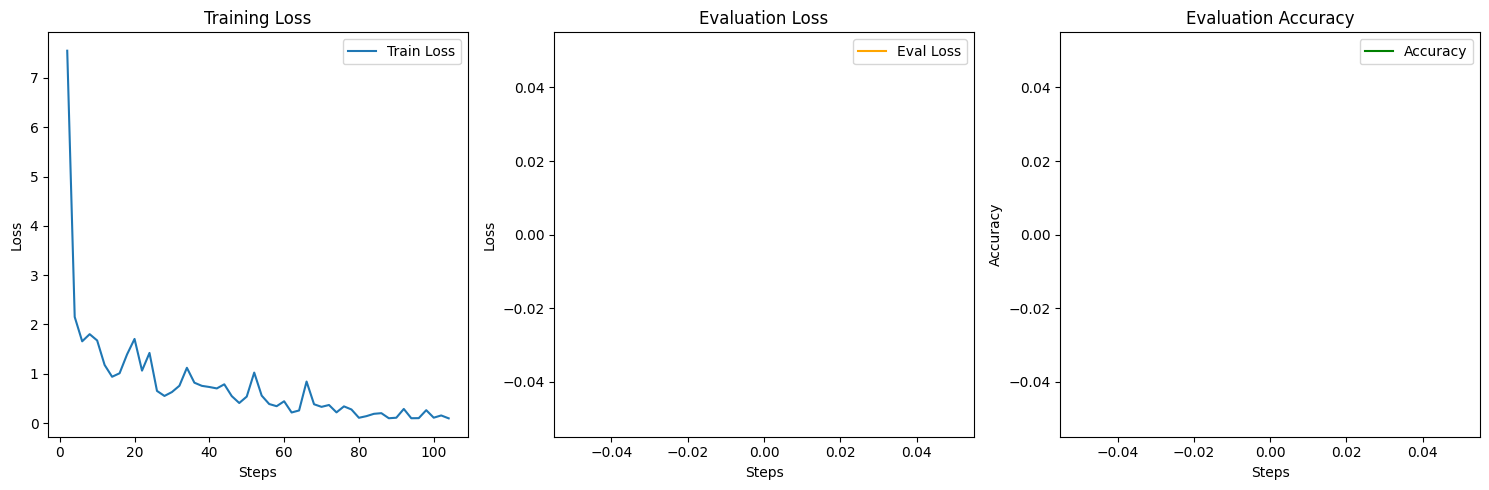

In [26]:
import matplotlib.pyplot as plt

# Extract metrics from trainer state
log_history = trainer.state.log_history

steps = []
train_loss = []
eval_steps = []
eval_loss = []
accuracy = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_loss.append(entry['loss'])
        steps.append(entry['step'])
    if 'eval_loss' in entry and 'step' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])
    if 'accuracy' in entry and 'step' in entry:
        accuracy.append(entry['accuracy'])
        eval_steps.append(entry['step'])

# Plot metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(steps, train_loss, label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(eval_steps, eval_loss, label="Eval Loss", color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evaluation Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(eval_steps, accuracy, label="Accuracy", color='green')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
score_model = VisionEncoderDecoderModel.from_pretrained('/kaggle/working/vit-ocr')
print(score_model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

# Inference

In [28]:
file_image = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0055.png'
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = Image.open(file_image).convert("RGB")
score_time = time.time()

pixel_values = processor(image, return_tensors="pt").pixel_values
# text = "industry, ' Mr. Brown commented icily. ' Let us have a"
# if torch.cuda.is_available():
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)
# # inference
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

score_time = time.time() - score_time
print('score_time (sec)', score_time)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


MH20TC640B
score_time (sec) 0.4045259952545166


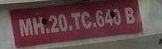

In [29]:
image

In [30]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

def compare_string(true_label, pred_label):
    
    true_label = true_label.replace(" ", "").replace('-','').replace('0','O')
    pred_label =  pred_label.replace(" ", "").replace('-','').replace('0','O')
    
    if pred_label == true_label:
        return True
    
    return False

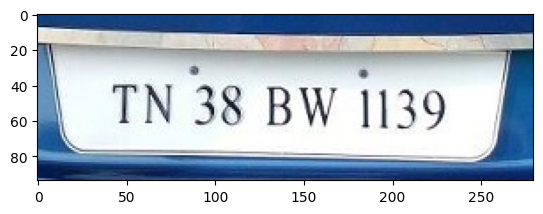

true_label TN38BW1139
pred_label TN38BV1139


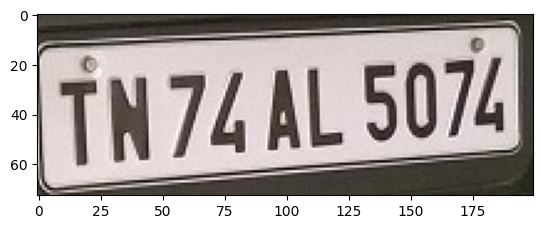

true_label TN74A5L074
pred_label TN74AL5074


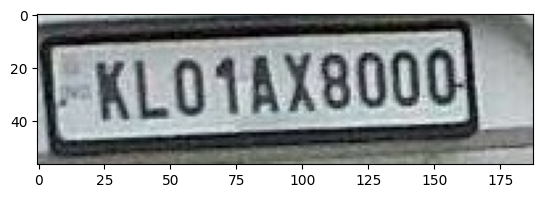

true_label KL01AX8000
pred_label KL01AX800


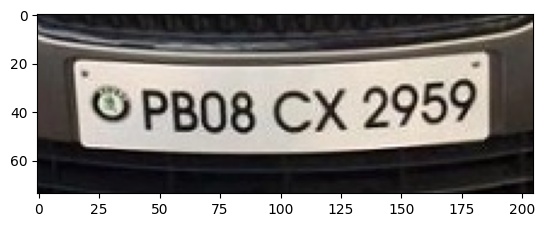

true_label PB08CX2959
pred_label OP08CX2959


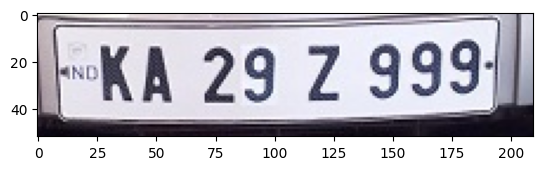

true_label AA29Z999
pred_label KA29Z999


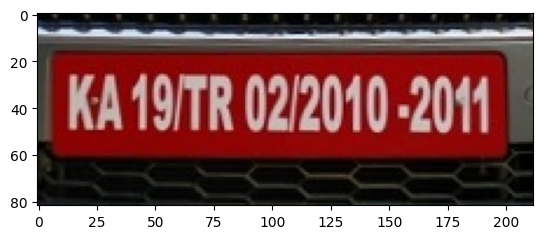

true_label KA19TR0220102011
pred_label KA19TR02201D1201


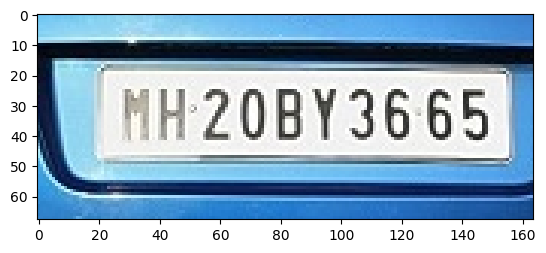

true_label MH20BY3665
pred_label MH203BY665


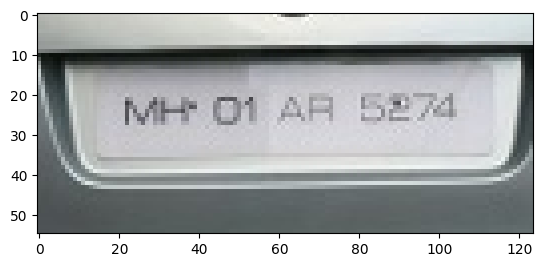

true_label MH01AR5274
pred_label MH01ARB274


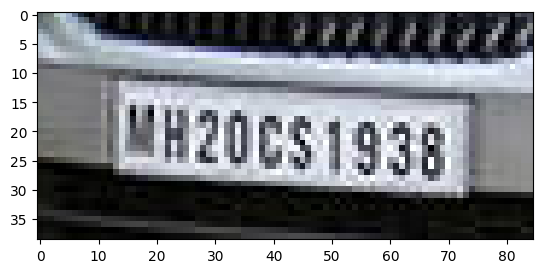

true_label H20CS1938
pred_label MH20CS1938


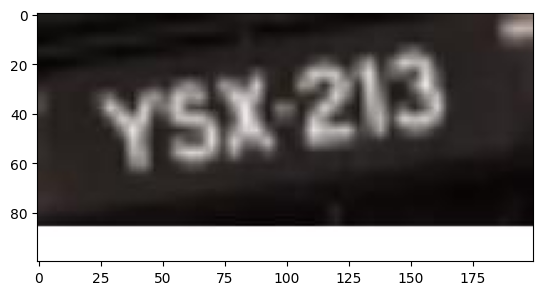

true_label YSX-213
pred_label Y5X-213


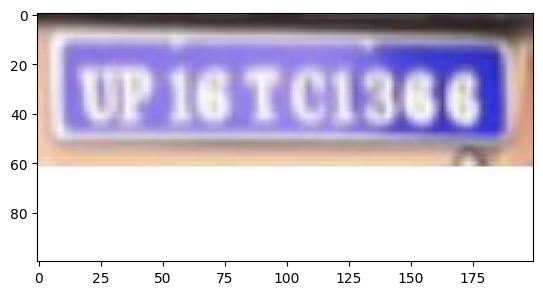

true_label UP16TC1366
pred_label UP10TC1300


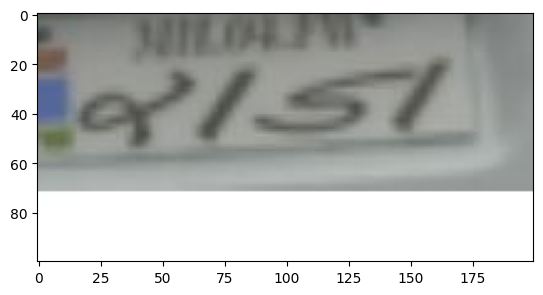

true_label A151
pred_label R15L51


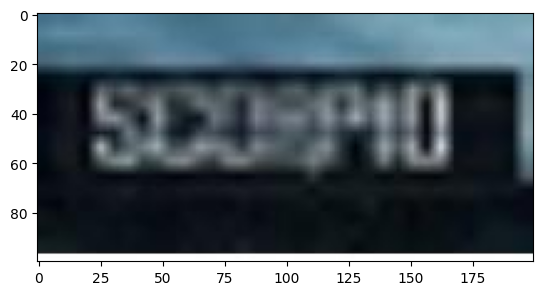

true_label SCORPIO
pred_label SIDJ-PID


In [32]:
correct_char = 0
total_char = 0
correct = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for _, val  in test_df.iterrows():
    
    image = Image.open(val['file_name']).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    true_label = val['text']  

#     pr = prediction[i]
#         tr = y_true[i]
#     total_char += len(true_label)
    correct_char += SequenceMatcher(None, true_label, pred_label).ratio()
    
    for j in range(min(len(true_label), len(pred_label))):
        if true_label[j] == pred_label[j]:
           correct_char += 1
            
    if compare_string(true_label, pred_label) :
        correct += 1
    else:
        plt.imshow(np.asarray(image))
        plt.show()
        print('true_label',true_label)
        print('pred_label',pred_label)

# Result on test dataset

In [33]:
print(f'correct {correct}, total {len(test_df)}')
print('performance on test  data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/test_df.shape[0]))
print('Correct words predicted      : %.2f%%' %(correct*100/test_df.shape[0]))

correct 29, total 42
performance on test  data
Correct characters predicted : 822.12%
Correct words predicted      : 69.05%


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


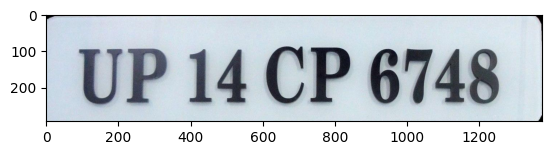

True Label: /kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations/0031.xml
Predicted Label: UP 14 CP 6748.


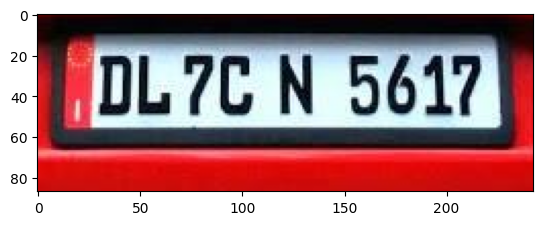

True Label: /kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations/0067.xml
Predicted Label: ( DL7CN 5617 )
Character Accuracy: 0.0594
String Accuracy: 0.0000


In [34]:
import torch
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Assuming lic_df is your DataFrame with columns 'file' and 'label'
# Example DataFrame
lic_df = pd.DataFrame({
    'file': ['/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0029.png', '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0015.png'],  # Replace with actual file paths
    'label': ['/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations/0031.xml', '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations/0067.xml']  # Replace with actual labels
})

# Load your pre-trained model and processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize metrics
correct_char = 0
total_char = 0
correct = 0

def compare_string(s1, s2):
    return s1 == s2

for _, val in lic_df.iterrows():
    image = Image.open(val['file']).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    true_label = val['label']
    
    # Update character-level metrics
    correct_char += SequenceMatcher(None, true_label, pred_label).ratio() * len(true_label)
    total_char += len(true_label)
    
    # Update string-level accuracy
    if compare_string(true_label, pred_label):
        correct += 1
    else:
        plt.imshow(np.asarray(image))
        plt.show()
        print('True Label:', true_label)
        print('Predicted Label:', pred_label)

# Calculate final metrics
character_accuracy = correct_char / total_char
string_accuracy = correct / len(lic_df)

print(f'Character Accuracy: {character_accuracy:.4f}')
print(f'String Accuracy: {string_accuracy:.4f}')


# Result on Car DataSet

In [35]:
print('performance on original data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/lic_df.shape[0]))
print('Correct words predicted      : %.2f%%' %(correct*100/lic_df.shape[0]))

performance on original data
Correct characters predicted : 516.83%
Correct words predicted      : 0.00%
